# 1.6g: The Cluster Revealed

## Parameters

In [12]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# PCA basis selection (for spherical coordinates)
NORTH_PC = 2
MERIDIAN_PC = 1
EQUINOX_PC = 3

# Volume filter
R_MIN = 0.0
R_MAX = 0.0002
Z_MIN = -0.023
Z_MAX = 0.038

# Point size scaling
BASE_SIZE = 500  # Maximum size (for closest tokens)
ALPHA = 0.5     # Transparency
EPSILON = 0.01  # Offset for inverse square to prevent division by zero

# Color
POINT_COLOR = 'steelblue'

# Visualization
FIGSIZE = (16, 8)
DPI = 200

## Imports

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Device Detection

In [14]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [15]:
# Load W (full vocabulary)
tensor_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(tensor_path)["W"]
W = W_bf16.to(torch.float32).to(device)
N, d = W.shape

print(f"Loaded W: {W.shape}")
print(f"  {N:,} tokens in {d:,} dimensions")

Loaded W: torch.Size([151936, 2560])
  151,936 tokens in 2,560 dimensions


In [16]:
# Load cluster-centric reference frame
ref_path = Path(f"../tensors/{MODEL_NAME}/1.6a_cluster_reference_frame.safetensors")
ref_data = load_file(ref_path)
cluster_centroid = ref_data['cluster_centroid'].to(device)
eigenvectors = ref_data['W_eigenvectors'].to(device)

print(f"\nLoaded reference frame:")
print(f"  Cluster centroid: {cluster_centroid.shape}")
print(f"  Centroid norm: {torch.linalg.vector_norm(cluster_centroid).item():.6f}")
print(f"  PCA eigenvectors: {eigenvectors.shape}")


Loaded reference frame:
  Cluster centroid: torch.Size([2560])
  Centroid norm: 0.370917
  PCA eigenvectors: torch.Size([2560, 2560])


## Define Spherical Basis

In [17]:
def get_pc_vector(pcs, index):
    """Get PC vector by index, with sign flip for negative indices."""
    pc_num = abs(index) - 1
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector

north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

print(f"\nSpherical basis defined:")
print(f"  North: PC{NORTH_PC}")
print(f"  Meridian: PC{MERIDIAN_PC}")
print(f"  Equinox: PC{EQUINOX_PC}")


Spherical basis defined:
  North: PC2
  Meridian: PC1
  Equinox: PC3


## Compute Spherical Coordinates from Cluster Centroid

In [18]:
print("\nComputing spherical coordinates for ALL tokens from cluster centroid...\n")

# Translate to cluster-centric frame
W_centered = W - cluster_centroid

# Project onto basis
x = W_centered @ meridian
y = W_centered @ equinox
z = W_centered @ north

# Spherical coordinates
r = torch.sqrt(x**2 + y**2 + z**2)
lat_rad = torch.asin(torch.clamp(z / r, -1, 1))
lat_deg = torch.rad2deg(lat_rad)
lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)

print(f"✓ Spherical coordinates computed for all {N:,} tokens")
print(f"\nRadial distance statistics (full dataset):")
print(f"  Min: {r.min().item():.6f}")
print(f"  Max: {r.max().item():.6f}")
print(f"  Mean: {r.mean().item():.6f}")
print(f"  Median: {r.median().item():.6f}")


Computing spherical coordinates for ALL tokens from cluster centroid...

✓ Spherical coordinates computed for all 151,936 tokens

Radial distance statistics (full dataset):
  Min: 0.000000
  Max: 1.122656
  Mean: 0.162215
  Median: 0.159331


## Filter to Target Volume

In [19]:
print(f"\nFiltering to volume: r ∈ [{R_MIN}, {R_MAX}], z ∈ [{Z_MIN}, {Z_MAX}]\n")

# Apply filters
mask = (r >= R_MIN) & (r <= R_MAX) & (z >= Z_MIN) & (z <= Z_MAX)
n_filtered = mask.sum().item()

# Extract filtered coordinates
r_filtered = r[mask]
lat_deg_filtered = lat_deg[mask]
lon_deg_filtered = lon_deg[mask]
z_filtered = z[mask]

print(f"✓ Filtered to {n_filtered:,} tokens")
print(f"  ({100 * n_filtered / N:.3f}% of vocabulary)")
print(f"\nFiltered dataset statistics:")
print(f"  r: [{r_filtered.min().item():.6f}, {r_filtered.max().item():.6f}]")
print(f"  z: [{z_filtered.min().item():.6f}, {z_filtered.max().item():.6f}]")


Filtering to volume: r ∈ [0.0, 0.0002], z ∈ [-0.023, 0.038]

✓ Filtered to 2,212 tokens
  (1.456% of vocabulary)

Filtered dataset statistics:
  r: [0.000000, 0.000151]
  z: [-0.000049, 0.000035]


## Compute Point Sizes

In [20]:
print("\nComputing point sizes...\n")

# Convert to numpy
r_np = r_filtered.cpu().numpy()
lat_np = lat_deg_filtered.cpu().numpy()
lon_np = lon_deg_filtered.cpu().numpy()

# Inverse square scaling: close = MUCH bigger, far = much smaller
r_max = r_np.max()
r_min = r_np.min()

# Normalize distances to [0, 1] range
r_normalized = (r_np - r_min) / (r_max - r_min + 1e-10)  # Add epsilon to avoid division by zero

# Inverse square with offset to prevent division by zero
sizes = BASE_SIZE * (1 / (r_normalized + EPSILON))**2

# Rescale to reasonable range
sizes = sizes / sizes.max() * BASE_SIZE

print(f"✓ Point sizes computed")
print(f"  Size range: [{sizes.min():.2f}, {sizes.max():.2f}]")
print(f"  Mean size: {sizes.mean():.2f}")


Computing point sizes...

✓ Point sizes computed
  Size range: [0.05, 500.00]
  Mean size: 378.47


## Mollweide Sky Map


Creating Mollweide sky map...



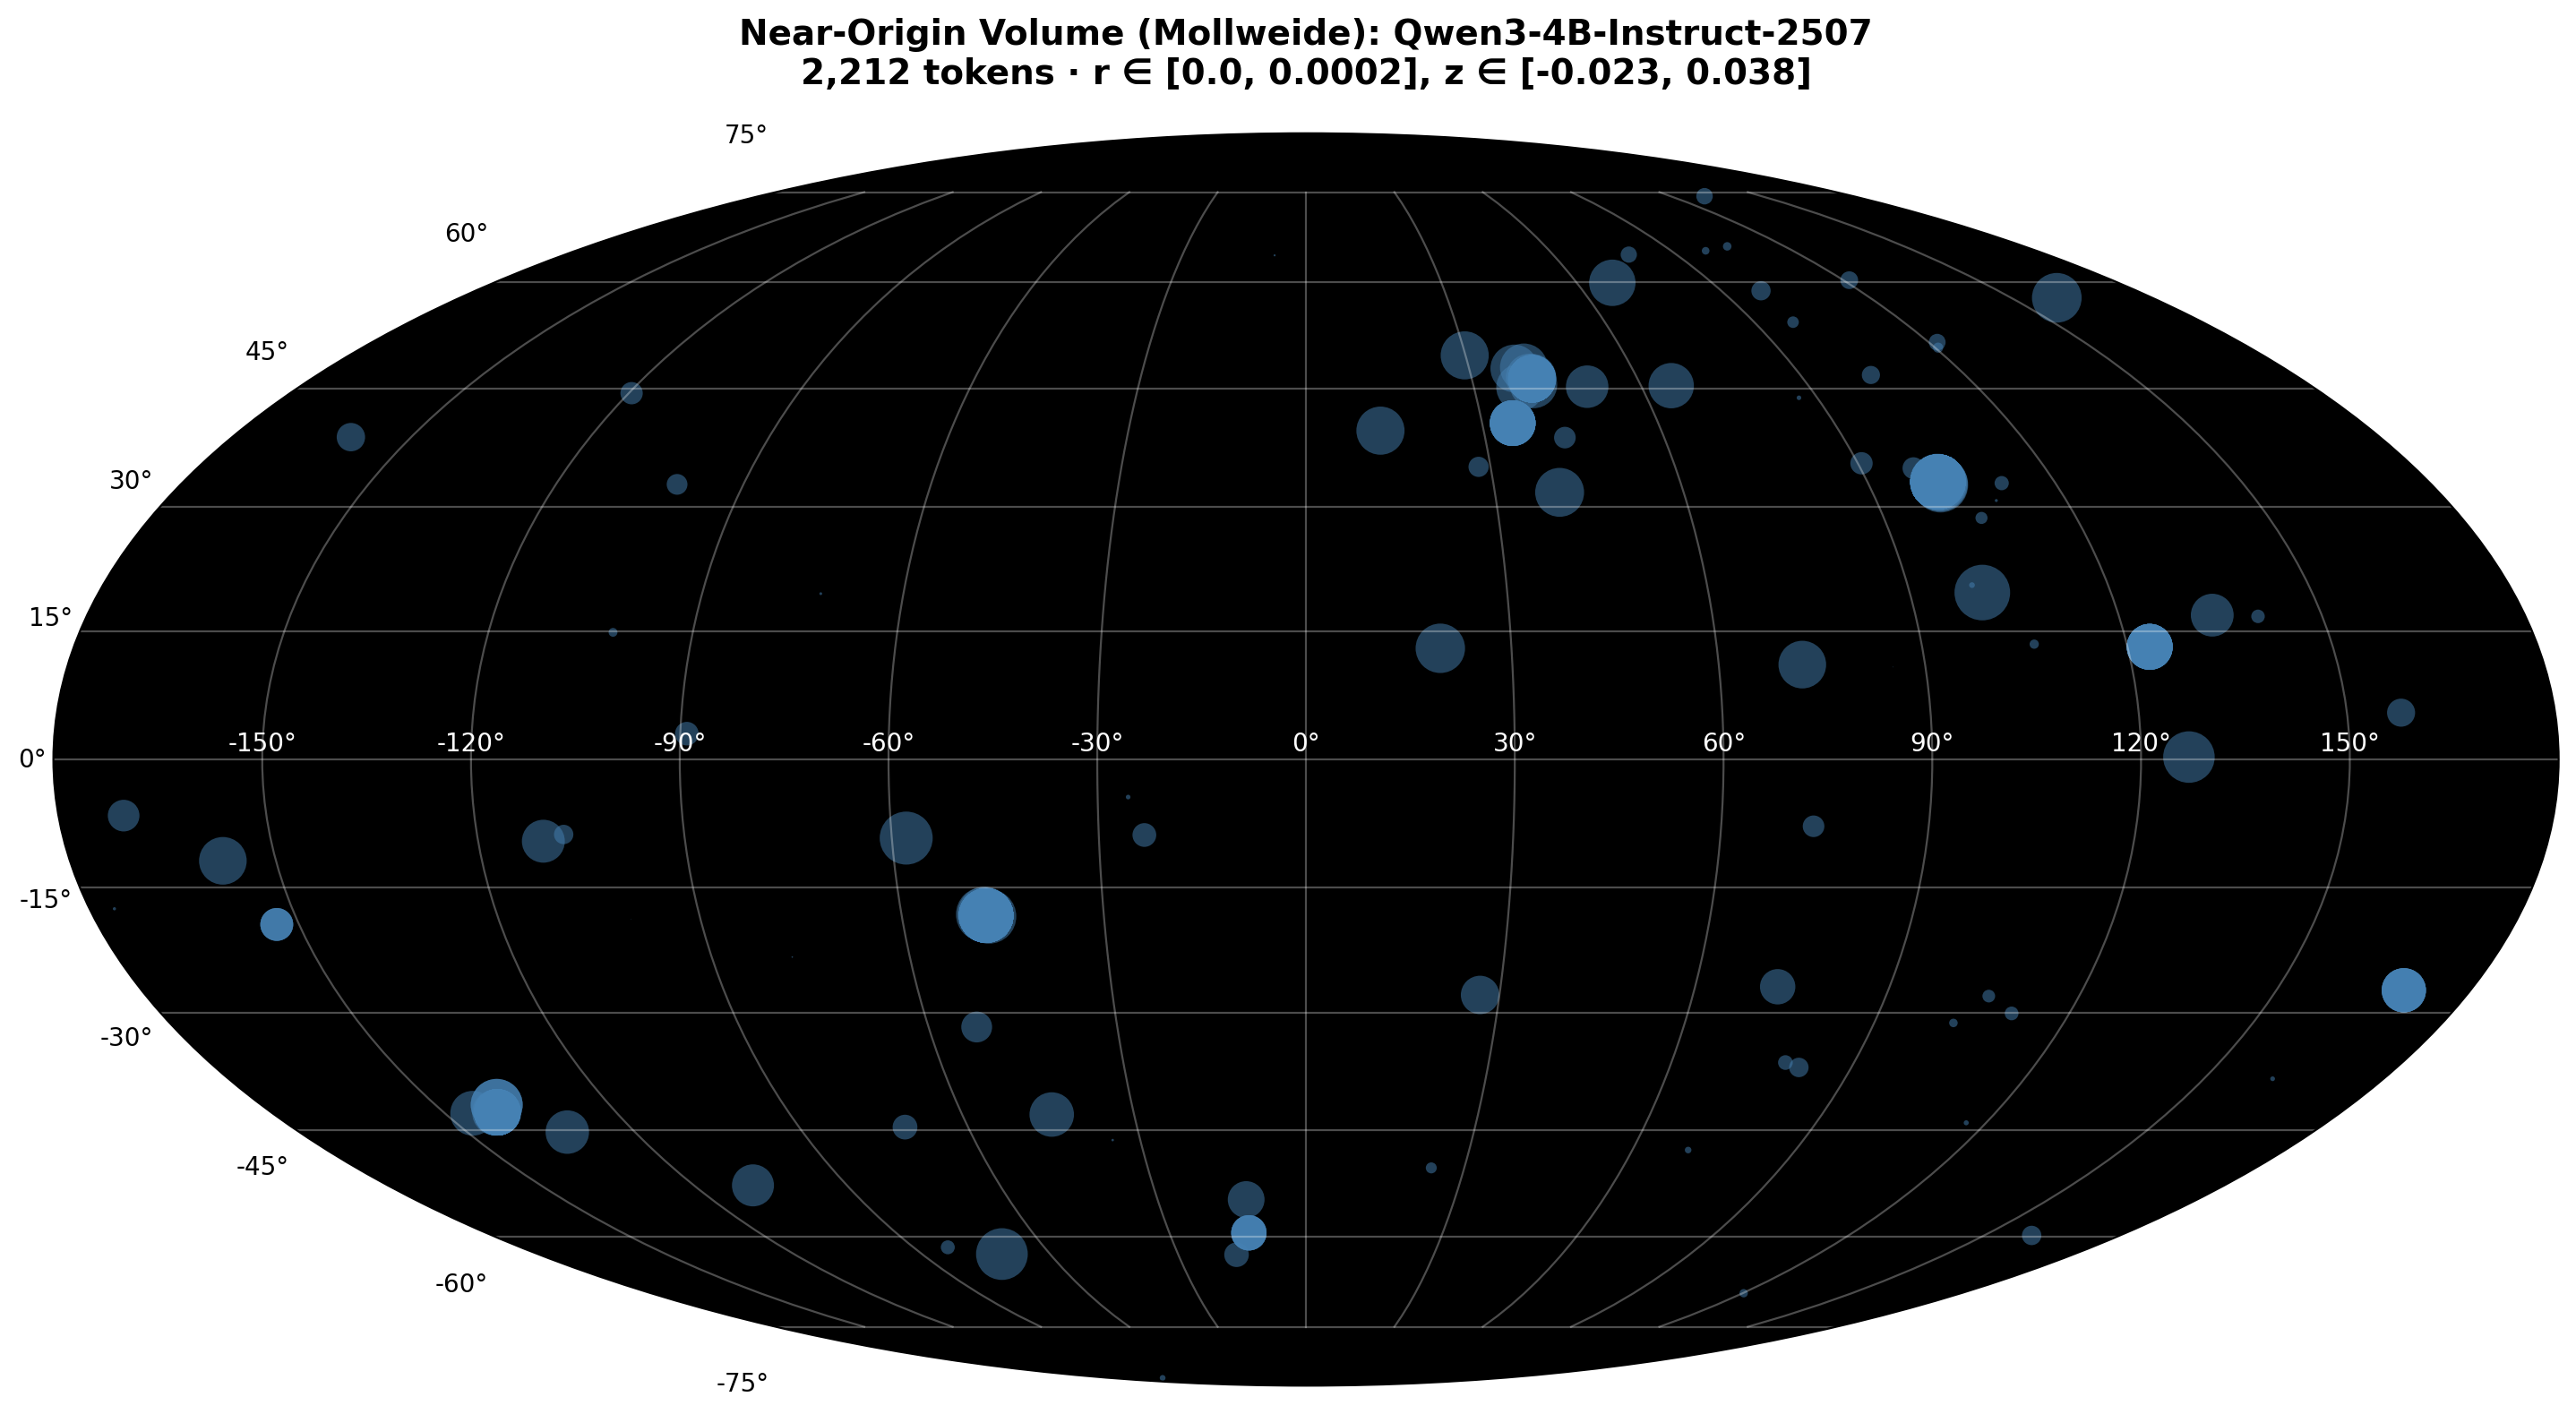

✓ Mollweide sky map complete


In [21]:
print(f"\nCreating Mollweide sky map...\n")

# Convert to radians for plotting
lon_rad = np.deg2rad(lon_np)
lat_rad = np.deg2rad(lat_np)

# Create figure
fig = plt.figure(figsize=FIGSIZE, dpi=DPI)
ax = fig.add_subplot(111, projection='mollweide')
ax.set_facecolor('black')

# Scatter plot
ax.scatter(lon_rad, lat_rad, 
           s=sizes, 
           alpha=ALPHA, 
           c=POINT_COLOR,
           edgecolors='none',
           rasterized=True)

# Formatting
ax.grid(True, alpha=0.3, color='white')
ax.set_title(f'Near-Origin Volume (Mollweide): {MODEL_NAME}\n' + 
             f'{n_filtered:,} tokens · r ∈ [{R_MIN}, {R_MAX}], z ∈ [{Z_MIN:.3f}, {Z_MAX:.3f}]',
             color='black', pad=20, fontsize=14, fontweight='bold')

# Set tick colors
for label in ax.get_xticklabels():
    label.set_color('white')
for label in ax.get_yticklabels():
    label.set_color('black')

plt.tight_layout()
plt.show()

print("✓ Mollweide sky map complete")

## Polar (Equatorial) Sky Map


Creating polar sky map...



/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_42685/3995770653.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(d)}°' for d in tick_degs])


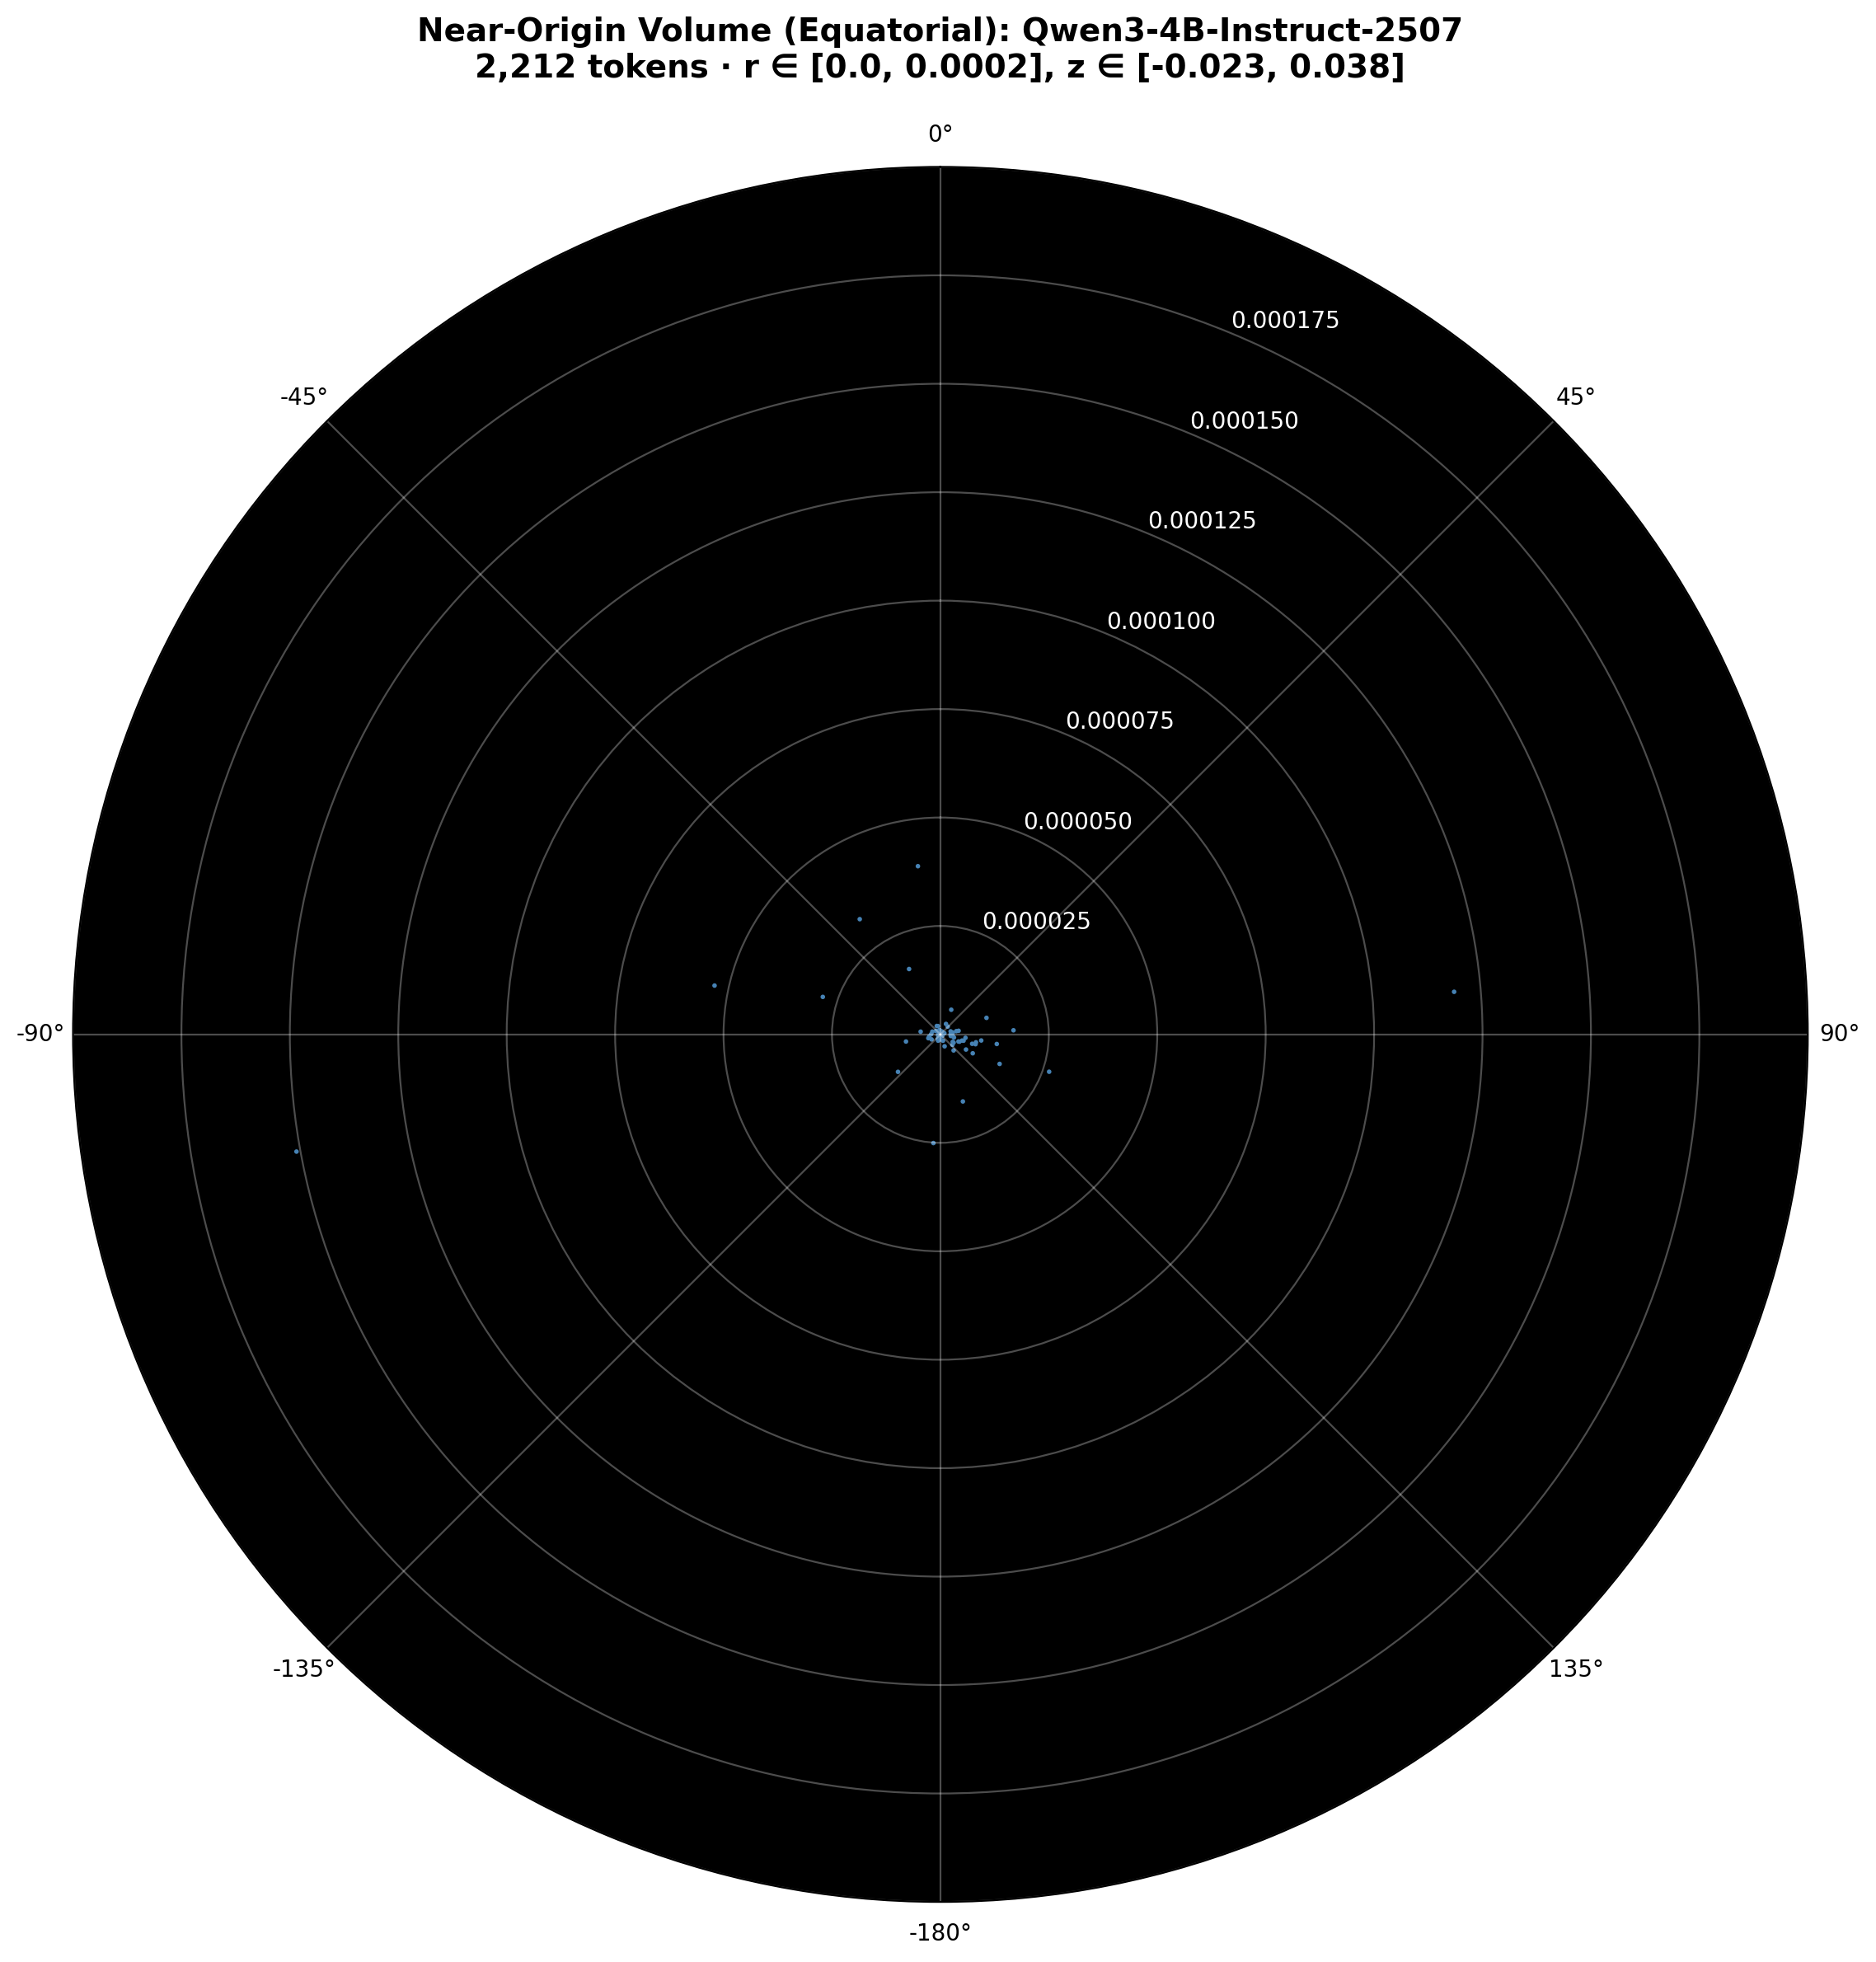

✓ Polar sky map complete


In [22]:
print(f"\nCreating polar sky map...\n")

# Create figure
fig = plt.figure(figsize=(12, 12), dpi=DPI)
ax = fig.add_subplot(111, projection='polar')
ax.set_facecolor('black')

# Scatter plot
ax.scatter(lon_rad, r_np, 
           s=4.0, 
           alpha=1.0, 
           c=POINT_COLOR,
           edgecolors='none',
           rasterized=True)

# Formatting
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.grid(True, alpha=0.3, color='white')
ax.set_title(f'Near-Origin Volume (Equatorial): {MODEL_NAME}\n' + 
             f'{n_filtered:,} tokens · r ∈ [{R_MIN}, {R_MAX}], z ∈ [{Z_MIN:.3f}, {Z_MAX:.3f}]',
             color='black', pad=20, fontsize=14, fontweight='bold')

# Get the default tick positions (in radians)
tick_locs = ax.get_xticks()

# Convert each tick from radians to degrees
tick_degs = np.rad2deg(tick_locs)

# Wrap to -180 to 180 range
tick_degs = ((tick_degs + 180) % 360) - 180

# Set the labels (but keep original positions)
ax.set_xticklabels([f'{int(d)}°' for d in tick_degs])

# Set tick colors
for label in ax.get_xticklabels():
    label.set_color('black')
for label in ax.get_yticklabels():
    label.set_color('white')

# Set radial limits to match filtered data
ax.set_rlim(bottom=R_MIN, top=R_MAX)

plt.tight_layout()
plt.show()

print("✓ Polar sky map complete")